In [28]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error



In [29]:
# --- 1. DATA LOADING AND INITIAL CLEANING ---

try:
    df = pd.read_csv('SCMS_Delivery_History_Dataset.csv')
except FileNotFoundError:
    print("--- ⚠️ WARNING: Using Dummy Data ---")
    # Generate dummy data structure matching the project's columns for demonstration
    np.random.seed(42) # for reproducibility
    data = {
        'ID': range(300),
        'Project Code': [f'PC{i%5}' for i in range(300)],
        'Country': np.random.choice(['USA', 'INDIA', 'GERMANY', 'CHINA', 'MEXICO'], 300),
        'Shipment Mode': np.random.choice(['Air', 'Ocean', 'Road', 'Air', 'Ocean'], 300),
        'Line Item Quantity': np.random.randint(10, 500, 300),
        'Line Item Value': np.random.uniform(500, 5000, 300),
        'Freight Cost (USD)': [f'{w:.2f}' for w in np.random.uniform(50, 1500, 300)], # Simulate object type
        'Line Item Insurance (USD)': np.random.uniform(10, 150, 300),
        'Weight (Kilograms)': [f'{w:.2f} kg' for w in np.random.uniform(10, 1000, 300)], # Simulate object type with units
        'Vendor': np.random.choice([f'Vendor_{i}' for i in range(15)], 300),
        'Manufacturing Site': np.random.choice([f'Site_{i}' for i in range(5)], 300),
        'Pack Price': np.random.uniform(5, 50, 300),
        'Unit Price': np.random.uniform(1, 10, 300),
        'PQ First Sent to Client Date': pd.to_datetime('2024-01-01') + pd.to_timedelta(np.random.randint(1, 100, 300), unit='D'),
        'PO Sent to Vendor Date': pd.to_datetime('2024-01-01') + pd.to_timedelta(np.random.randint(10, 150, 300), unit='D'),
        # Adding NaNs to Freight Cost for Imputation Demo
        'Freight Cost (USD)': [np.nan if i % 15 == 0 else x for i, x in enumerate(data['Freight Cost (USD)'])]
    }
    # Convert Freight Cost and Weight to strings with noise for robust cleaning demo
    data['Freight Cost (USD)'] = [str(x).replace('.', ',') if i % 17 == 0 else str(x) for i, x in enumerate(data['Freight Cost (USD)'])]
    df = pd.DataFrame(data)
    # Ensure date columns exist for feature engineering, even if simplified
    for col in ['PQ First Sent to Client Date', 'PO Sent to Vendor Date']:
        if col not in df.columns: df[col] = pd.NaT




In [30]:
# --- 2. TARGET CREATION AND ROBUST CLEANUP FUNCTION ---

def clean_and_prepare_data(df):
    """Performs cleanup, feature engineering, and calculates the target variable."""
    df = df.copy()

    # 2.1. Robust Data Cleaning (Handles common string/object issues)
    # Convert comma separators to periods for numeric conversion
    df['Freight Cost (USD)'] = df['Freight Cost (USD)'].astype(str).str.replace(',', '.', regex=False)

    # Clean up currency/unit symbols and convert to numeric
    for col in ['Freight Cost (USD)', 'Weight (Kilograms)']:
        if df[col].dtype == 'object' or df[col].dtype == 'float64' or df[col].dtype == 'int64':
            df[col] = df[col].astype(str).str.replace(r'[$,A-Za-z\s]', '', regex=True)
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # 2.2. Target Variable Calculation
    df['Total_Shipment_Cost'] = (
        df['Line Item Value'].fillna(0) +
        df['Freight Cost (USD)'].fillna(0) +
        df['Line Item Insurance (USD)'].fillna(0)
    )

    # Drop records with zero or negative cost (not valid shipments for modeling)
    df = df[df['Total_Shipment_Cost'] > 0].copy()

    # Use log transformation on the target to stabilize variance (crucial for regression)
    df['log_Total_Cost'] = np.log1p(df['Total_Shipment_Cost'])

    # 2.3. Feature Engineering (Temporal Novelty)
    date_cols = ['PQ First Sent to Client Date', 'PO Sent to Vendor Date']
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    if all(col in df.columns for col in date_cols):
        # Calculate Planning Lead Time (in days)
        df['Planning_Lead_Time_Days'] = (df['PO Sent to Vendor Date'] - df['PQ First Sent to Client Date']).dt.days.clip(lower=0)
    else:
        # If dates are missing, create a placeholder column for the pipeline
        df['Planning_Lead_Time_Days'] = 0

    return df

df_clean = clean_and_prepare_data(df)



/var/folders/23/p28dsb_14zb9r0b9365phr3h0000gn/T/ipykernel_97783/1857187081.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
/var/folders/23/p28dsb_14zb9r0b9365phr3h0000gn/T/ipykernel_97783/1857187081.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


In [31]:
# --- 3. FEATURE AND TARGET DEFINITION ---

TARGET_COL = 'log_Total_Cost'

# Define all numerical features we want to use (including the engineered one)
NUMERIC_COLS = [
    'Line Item Quantity', 'Pack Price', 'Unit Price',
    'Weight (Kilograms)', 'Planning_Lead_Time_Days'
]

# Define all categorical features we want to use
CATEGORICAL_COLS = [
    'Country', 'Shipment Mode', 'Vendor', 'Manufacturing Site'
]

# Define Predictors (X) and Target (Y)
X = df_clean[NUMERIC_COLS + CATEGORICAL_COLS]
Y = df_clean[TARGET_COL]

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)




In [32]:
# --- 4. PREPROCESSING PIPELINE ---

# 4.1. Numerical Pipeline (Imputation -> Scaling)
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 4.2. Categorical Pipeline (Imputation -> One-Hot Encoding)
categorical_pipeline = Pipeline(steps=[
    # Use 'Unknown' for missing categories for better modeling than mode imputation
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    # Handle unknown categories in the test set gracefully
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 4.3. Column Transformer (Combines pipelines)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, NUMERIC_COLS),
        ('cat', categorical_pipeline, CATEGORICAL_COLS)
    ],
    remainder='passthrough'
)



In [33]:
# --- 5. MODEL DEFINITION AND TRAINING ---

# Define the XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

# Define the full modeling pipeline
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

# Train the model
print("\n--- Training XGBoost Model ---")
full_pipeline.fit(X_train, Y_train)
print("Training Complete.")





--- Training XGBoost Model ---
Training Complete.


In [34]:
# --- 6. EVALUATION ---

# Make predictions on the test set
Y_pred_log = full_pipeline.predict(X_test)

# Convert predictions back from log-scale to actual USD values
Y_test_actual = np.expm1(Y_test) # Inverse of np.log1p
Y_pred_actual = np.expm1(Y_pred_log)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(Y_test_actual, Y_pred_actual))
mape = mean_absolute_percentage_error(Y_test_actual, Y_pred_actual) * 100

print("\n--- Model Evaluation (Actual USD Values) ---")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:,.2f}%")
print("------------------------------------------")




--- Model Evaluation (Actual USD Values) ---
Root Mean Squared Error (RMSE): $56,540.37
Mean Absolute Percentage Error (MAPE): 20.95%
------------------------------------------



--- Calculating SHAP Values Directly via XGBoost ---


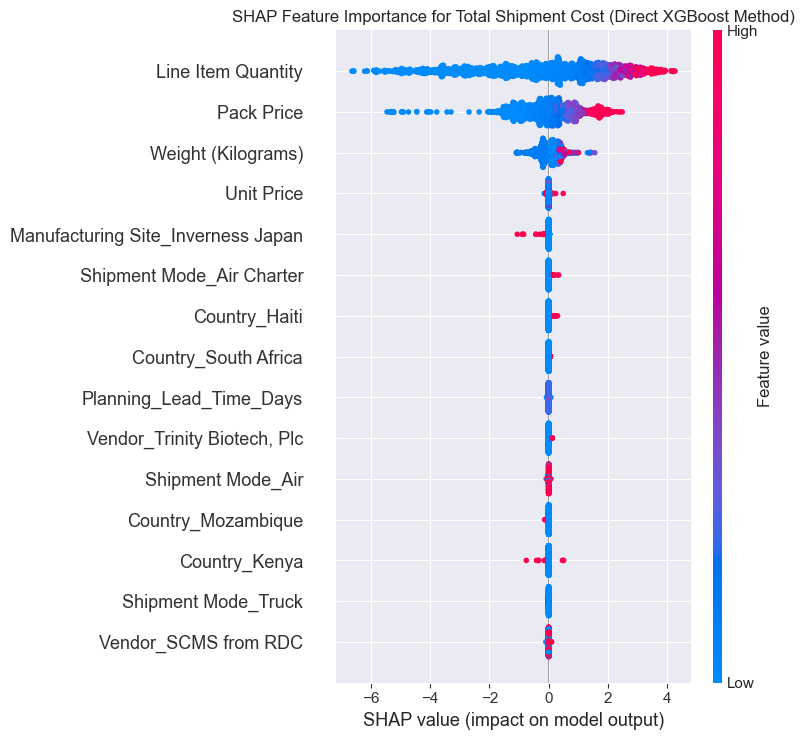


SHAP analysis plot generated using XGBoost's built-in contribution calculation.


In [35]:
# --- 7. MODEL INTERPRETATION (SHAP Values) - XGBoost Direct Method ---

# Get the fitted XGBoost model and processed data
explainer_model = full_pipeline['regressor']
booster = explainer_model.get_booster()
X_test_processed = full_pipeline['preprocessor'].transform(X_test)
X_train_processed = full_pipeline['preprocessor'].transform(X_train) # Get processed training data (needed for base value)

# 1. Get the processed feature names after One-Hot Encoding
ohe = full_pipeline['preprocessor'].named_transformers_['cat']['onehot']
categorical_feature_names = list(ohe.get_feature_names_out(CATEGORICAL_COLS))
feature_names = NUMERIC_COLS + categorical_feature_names

print("\n--- Calculating SHAP Values Directly via XGBoost ---")

# --- 🛠️ XGBOOST DIRECT SHAP CALCULATION ---

# Convert test data to DMatrix (required for pred_contribs)
dtest = xgb.DMatrix(X_test_processed, feature_names=feature_names)

# Use booster.predict with pred_contribs=True to get SHAP values directly
# The output includes an extra column for the base value (expected value),
# so we slice it off [:, :-1]
shap_values = booster.predict(dtest, pred_contribs=True)[:, :-1]

# Calculate the expected value (base value) - often the mean prediction on training data
# Or use the explainer's expected_value if calculated differently
base_value = explainer_model.predict(X_train_processed).mean() # Approximate base value

# --- 🛠️ XGBOOST DIRECT SHAP CALCULATION END ---

# Plot feature importance (SHAP Summary Plot)
# Note: When getting SHAP values directly, the base value might not be automatically
#       passed to the plot. We can provide it if needed, but summary_plot often works without it.
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values,
    X_test_processed, # Pass the NumPy array here
    feature_names=feature_names,
    show=False,
    max_display=15 # Show top 15 features
)
plt.title("SHAP Feature Importance for Total Shipment Cost (Direct XGBoost Method)")
plt.tight_layout()
plt.show()

print("\nSHAP analysis plot generated using XGBoost's built-in contribution calculation.")

